In [1]:
#Inportar Programas#
import dolfin, mshr
import bempp.api
import numpy as np 

In [2]:
#Datos Principales. 
R = 2
Seg = 18

Q= np.array([1.0,1.0,0.75]) #Carga y posicion
PC=np.array([[1,0,0],[0.7,0.7,0],[-0.5,-0.5,0]])
w = 0.150 #kappa
es=80  #[-]
em=4   #[-]

ec=1.602176e-19 #[C]
kb=1.380648e-23 #[J/K]
T=300 #[K]
S1=1 #(ec/(kb*T))  #38.681 [C/J]

In [3]:
#Generar la malla de la Esfera#
dolfin.set_log_active(False)
geometry = mshr.Sphere(dolfin.Point(0,0,0), R, Seg) #Centro, Radio, Segmento#
mesh = mshr.generate_mesh(geometry,Seg)

In [4]:
#Generar espacios de funcionales de Fem y Bem#
from bempp.api import fenics_interface

fenics_space = dolfin.FunctionSpace(mesh, "CG", 1)
trace_space, trace_matrix = \
    fenics_interface.coupling.fenics_to_bempp_trace_data(fenics_space)
bempp_space = bempp.api.function_space(trace_space.grid, "DP", 0)

print("FEM dofs: {0}".format(mesh.num_vertices()))
print("BEM dofs: {0}".format(bempp_space.global_dof_count))
print("Density: %1.4f"%(bempp_space.global_dof_count/(4*np.pi*R**2)))

Calling FFC just-in-time (JIT) compiler, this may take some time.
FEM dofs: 2567
BEM dofs: 1640
Density: 32.6268


In [5]:
#Generar operadores de frontera de Fem y Bem#
id_op = bempp.api.operators.boundary.sparse.identity(trace_space, bempp_space, bempp_space)
mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)
if w==0:
    dlp = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space)
    slp = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space) 
else:
    dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w)
    slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w)

#Caso U_c#
id_op2 = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, bempp_space)
if w==0:
    dlp2 = bempp.api.operators.boundary.laplace.double_layer(bempp_space, bempp_space, bempp_space)
else:
    dlp2 = bempp.api.operators.boundary.modified_helmholtz.double_layer(bempp_space, bempp_space, bempp_space, w)

In [6]:
#Definir espacio funcional de Dolfin#
u = dolfin.TrialFunction(fenics_space)
v = dolfin.TestFunction(fenics_space)

In [7]:
#Creacion de funciones   
def U_c(x, n, domain_index, result):
    global Q,PC,em,S1
    result[:] = (S1 / (4.*np.pi*em))  * np.sum( Q / np.linalg.norm( x - PC, axis=1))
U_c = bempp.api.GridFunction(bempp_space, fun=U_c)

def dU_c(x, n, domain_index, result):
    global Q,PC,em,S1
    result[:] = -(S1/(4.*np.pi*em))   * np.sum( np.dot( x - PC , n)  * Q / (np.linalg.norm( x - PC, axis=1 )**3) )
dU_c = bempp.api.GridFunction(bempp_space, fun=dU_c)

Vuc = U_c.projections(bempp_space)
Vduc = dU_c.projections(bempp_space)


VS1 = ((em/es-1)*(0.5*id_op2 - dlp2)*U_c).projections(bempp_space)
A1 = (em/es)*((dlp2 - 0.5*id_op2)*U_c).projections(bempp_space)
A2 = -(em/es)*(slp*dU_c).projections(bempp_space)

#Construccion matriz derecha#

# EL rhs en FEM
rhs_fem = np.zeros(mesh.num_vertices())
# El rhs en BEM
rhs_bem = VS1 + A1 + A2
# La combinacion de rhs
rhs = np.concatenate([rhs_fem, rhs_bem])

In [8]:
#Construccion matriz izquierda#
from bempp.api.fenics_interface import FenicsOperator
from scipy.sparse.linalg.interface import LinearOperator
blocks = [[None,None],[None,None]]

trace_op = LinearOperator(trace_matrix.shape, lambda x:trace_matrix*x)

A = FenicsOperator((dolfin.inner(dolfin.nabla_grad(u),
                                 dolfin.nabla_grad(v)) ) * dolfin.dx)  
#Posicion de la matriz 2x2#
B00 = A.weak_form()
B01 = -trace_matrix.T * mass.weak_form().sparse_operator
B10 = (.5 * id_op - dlp).weak_form() * trace_op
B11 = slp.weak_form()*(em/es)
blocks[0][0] = B00  #A
blocks[0][1] = B01  #-ML
blocks[1][0] = B10  #0.5-K
blocks[1][1] = B11  #V

blocked = bempp.api.BlockedDiscreteOperator(np.array(blocks))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
#Calcular la solucion de la Ec. Ax=B#
it_count = 0
def count_iterations(x):
    global it_count
    it_count += 1

from scipy.sparse.linalg import gmres
soln, info = gmres(blocked, rhs, M=None, callback=count_iterations,tol=1e-4)  #Sin Precondicionador#

soln_fem = soln[:mesh.num_vertices()]
soln_bem = soln[mesh.num_vertices():]

print("Number of iterations: {0}".format(it_count))

Number of iterations: 5479


In [10]:
#Calcula todo el dominio de Fem y Bem a partir del borde calculado#

# Calcula el potencial real en el dominio FEM 
u = dolfin.Function(fenics_space)
u.vector()[:] = np.ascontiguousarray(np.real(soln_fem))
# Calcula el funcion solucion con los datos de Dirichlet en el borde
dirichlet_data = trace_matrix * soln_fem
dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=dirichlet_data)
# Calcula el funcion solucion con los datos de Neumann en el borde
neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=soln_bem)
#Caso u_c
dirichlet_uc_fun = U_c
#Caso du_c
neumann_duc_fun = dU_c

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


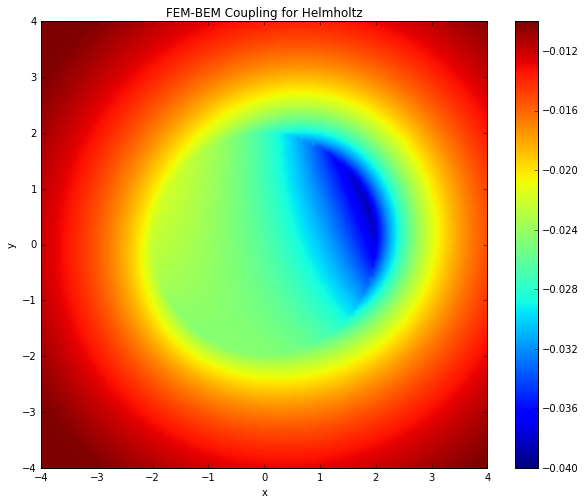

In [11]:
#Graficar solucion#

%matplotlib inline
bempp.api.global_parameters.hmat.eps = 1E-2

Nx=150
Ny=150
Z=0 #Posicion del plano
xmin, xmax, ymin, ymax=[-4,4,-4,4]
plot_grid = np.mgrid[xmin:xmax:Nx*1j,ymin:ymax:Ny*1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.array([Z]*plot_grid[0].size)))  #Modificacion del plano#
plot_me = np.zeros(points.shape[1], dtype=np.complex128)

x,y,z = points
us_x = np.logical_not(np.sqrt(x**2+y**2+z**2)<R)

if w==0:
    slpS_pot= bempp.api.operators.potential.laplace.single_layer(bempp_space, points[:,us_x])
    dlpS_pot= bempp.api.operators.potential.laplace.double_layer(trace_space, points[:,us_x])
    dlpS2_pot= bempp.api.operators.potential.laplace.double_layer(bempp_space, points[:,us_x])
else:
    slpS_pot= bempp.api.operators.potential.modified_helmholtz.single_layer(bempp_space, points[:,us_x], w)
    dlpS_pot= bempp.api.operators.potential.modified_helmholtz.double_layer(trace_space, points[:,us_x], w)
    dlpS2_pot= bempp.api.operators.potential.modified_helmholtz.double_layer(bempp_space, points[:,us_x], w)

#Dominio um#
fem_points = points[:, np.logical_not(us_x)].transpose()
fem_val = np.zeros(len(fem_points))
for p,point in enumerate(fem_points):
    result = np.zeros(1)
    u.set_allow_extrapolation(True) #Extrapola datos que no estan en el corte#
    u.eval(result, point)
    fem_val[p] = result[0]
plot_me[np.logical_not(us_x)] += fem_val

#Dominio us a partir de um y dum/dn#
plot_me[us_x] += dlpS_pot.evaluate(dirichlet_fun).flat
plot_me[us_x] -= (slpS_pot.evaluate(neumann_fun)*(em/es)).flat
plot_me[us_x] -= (slpS_pot.evaluate(neumann_duc_fun)*(em/es)).flat
plot_me[us_x] += (dlpS2_pot.evaluate(dirichlet_uc_fun)).flat

for i in range(len(Q)):
    plot_me[us_x] -= (S1 / (4.*np.pi*em))  * ( Q[i] / np.linalg.norm(np.transpose( points[:,us_x] ) - PC[i], axis=1))
    
plot_me = plot_me.reshape((Nx, Ny))
plot_me = plot_me.transpose()[::-1]

# Muestra el grafico
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(10, 8))
plt.imshow(np.real(plot_me), extent=[xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.clim(-0.010,-0.040)
plt.title("FEM-BEM Coupling for Helmholtz")
plt.show()

In [12]:
#Energia de solvatacion#
q_uF2 = 0
for i in range(len(PC)):
    Sum2 = u(PC[i])*Q[i]
    q_uF2 = q_uF2 + Sum2

E_Solv = 0.5*4.*np.pi*332.064*(q_uF2)
print('Energia de Solvatacion: {:7.2f} [kCal/mol]'.format(E_Solv) )

Energia de Solvatacion: -165.44 [kCal/mol]


In [14]:
#Energia de solvatacion teorica#
from an_solution import an_P
G2 = an_P(Q, PC, em, es, R, w, R , 10)
print(G2)

-164.586330948


In [15]:
#Error absoluto#
Error = np.abs( E_Solv/G2-1 )*100
print(Error)

0.519263793914
